# Process Navigation and Speed Data with basic image analysis
## Setup

In [43]:
! wget "https://arcxyon.com/wp-content/uploads/2025/08/ETS2_30-FPS_2025-08-03_15-28-27.mp4"

--2025-08-06 15:39:03--  https://arcxyon.com/wp-content/uploads/2025/08/ETS2_30-FPS_2025-08-03_15-28-27.mp4
Resolving arcxyon.com (arcxyon.com)... 217.160.0.209, 2001:8d8:100f:f000::200
Connecting to arcxyon.com (arcxyon.com)|217.160.0.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 582410628 (555M) [video/mp4]
Saving to: ‘ETS2_30-FPS_2025-08-03_15-28-27.mp4’

ETS2_30-FPS_2025-08 100%[===================>] 555.43M  39.5MB/s    in 15s     

2025-08-06 15:39:19 (37.7 MB/s) - ‘ETS2_30-FPS_2025-08-03_15-28-27.mp4’ saved [582410628/582410628]



In [44]:
import cv2

cap = cv2.VideoCapture("ETS2_30-FPS_2025-08-03_15-28-27.mp4")

In [45]:
import random

def get_random_from_video():
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    random_frame = random.randint(0, total_frames - 1)

    cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame)
    ret, frame = cap.read()
    return frame

In [4]:
import matplotlib.pyplot as plt

def show(img, cv2_img = True, size=(12, 10)):
    if cv2_img: 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=size) # img display size
    plt.imshow(img)
    plt.axis('off')
    plt.show()

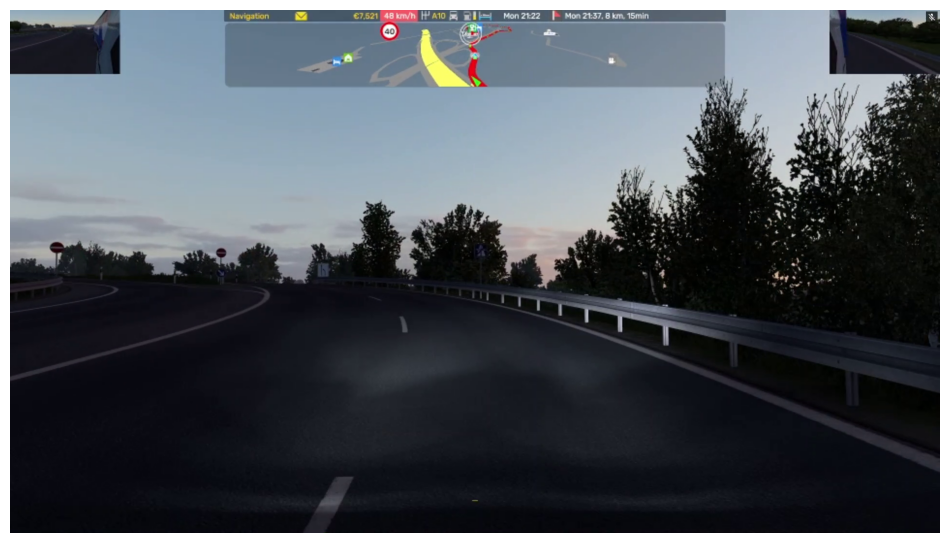

In [5]:
show(get_random_from_video())

## Preprocessing

For the navigation, crop the image:
- Top: 28
- Bottom: 900
- Left: 810
- Right: 810

For the speed:
- Top: 5
- Bottom: 1057
- Left: 770
- Right: 1125

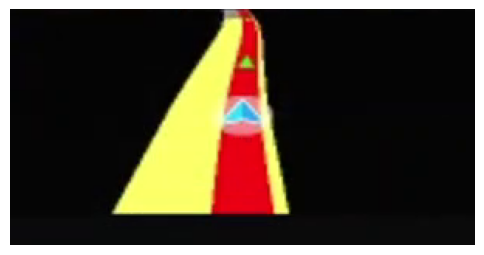

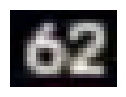

In [190]:
img = get_random_from_video()

# Image dimensions
height, width = img.shape[:2]

# --- Navigation crop ---
nav_top = 28
nav_bottom = height - 900 
nav_left = 810
nav_right = width - 810 

nav_img = img[nav_top:nav_bottom, nav_left:nav_right]

# --- Speed crop ---
speed_top = 5 
speed_bottom = height - 1057
speed_left = 770
speed_right = width - 1125

speed_img = img[speed_top:speed_bottom, speed_left:speed_right]

show(nav_img, size=(6, 4))
show(speed_img, size=(3, 1))

## Getting the speed
Because the input images are in low quality and the color and sharpnes is variing a loot, extracting the bright spots first and then apply a text recognition neural network maks it easy. The image should be sharpend and then only bright spots are extraced and feed into the image recognizer. Other methodes seemd not improving the result like: enhance_contrast_adaptive_threshold, denoise_image, binarize_otsu or invert_image


In [173]:
saved_img = img.copy()

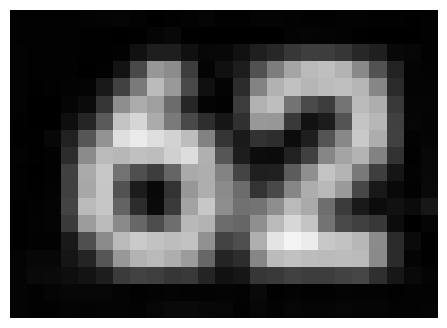

In [191]:
gray = cv2.cvtColor(speed_img, cv2.COLOR_BGR2GRAY)
show(gray, size=(6,4))

In [47]:
def sharpen(img):
    working_img = img.copy()
    # Unsharp Masking
    blurred = cv2.GaussianBlur(working_img, (0, 0), sigmaX=2)
    amount = 1.5
    return cv2.addWeighted(working_img, 1 + amount, blurred, -amount, 0)

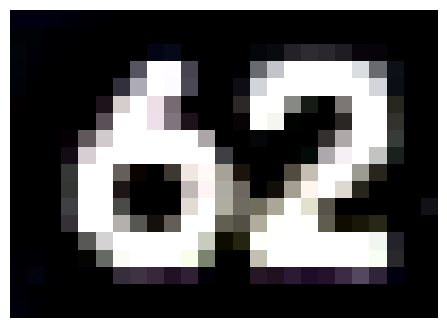

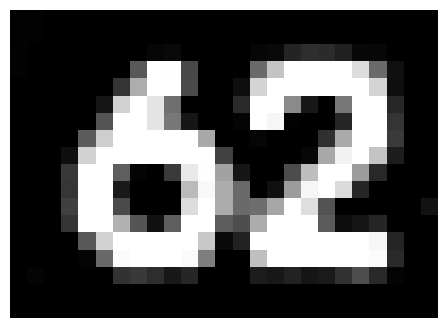

In [192]:
sharpend_speed_img_bgr = sharpen(speed_img)
sharpend_speed_img_gray = sharpen(gray)
show(sharpend_speed_img_bgr, size=(6, 4))
show(sharpend_speed_img_gray, size=(6, 4))

In [49]:
import numpy as np

def get_white(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # white is low saturation, high value
    lower_white = np.array([0, 0, 200])   # Hue=0, Sat=0 (no color), Value=200 (bright)
    upper_white = np.array([180, 30, 255])
    
    mask = cv2.inRange(hsv, lower_white, upper_white)
    
    return cv2.bitwise_and(img, img, mask=mask)

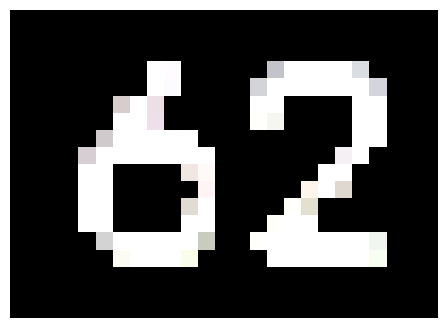

In [193]:
white_speed_img = get_white(sharpend_speed_img_bgr)
show(white_speed_img, size=(6,4))

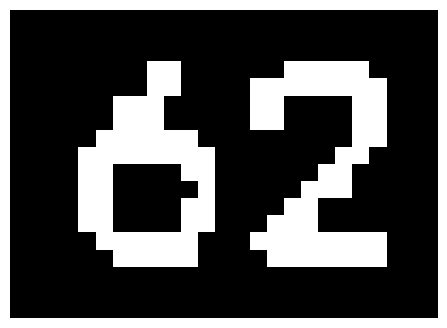

In [194]:
_, binary_img = cv2.threshold(sharpend_speed_img_gray, 200, 255, cv2.THRESH_BINARY)
show(binary_img, size=(6,4))

In [16]:
%%capture
! pip install easyocr

In [17]:
import easyocr
reader = easyocr.Reader(['en'])  # loads the model

In [195]:
white_speed_img_rgb = cv2.cvtColor(white_speed_img, cv2.COLOR_BGR2RGB)
white_results = reader.readtext(white_speed_img_rgb, detail=0)
print(white_results)

['62']


In [196]:
binary_img_rgb = cv2.cvtColor(binary_img, cv2.COLOR_BGR2RGB)
binary_results = reader.readtext(binary_img_rgb, detail=0)
print(binary_results)

['62']


In [197]:
speed_img_rgb = cv2.cvtColor(speed_img, cv2.COLOR_BGR2RGB)
orginal_results = reader.readtext(speed_img_rgb, detail=0)
print(orginal_results)

['62']


Note: When the speedlimit is overpassed, the background gets red. It seems that the binary variant with the gray image as base is more reliable while the white extraction methode works not well for the red images and the original unprocessed img worked not with the classification model.

## Getting the navigation

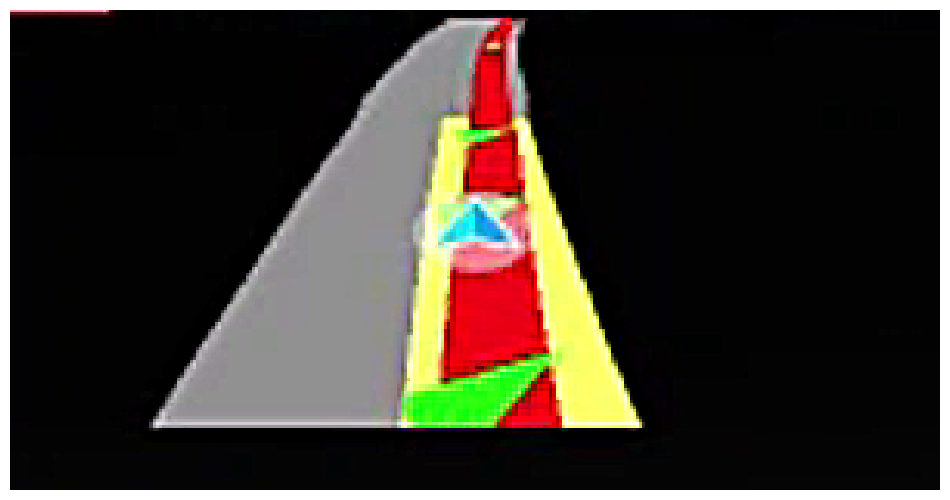

In [53]:
sharpend_nav_img = sharpen(nav_img)

show(sharpend_nav_img)

In [54]:
hsv = cv2.cvtColor(sharpend_nav_img, cv2.COLOR_BGR2HSV)

# Define color ranges for red, green, and blue in HSV
# Red has two ranges because it wraps around the hue circle
lower_red1 = np.array([0, 70, 50])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([170, 70, 50])
upper_red2 = np.array([180, 255, 255])

lower_green = np.array([36, 70, 50])
upper_green = np.array([89, 255, 255])

lower_blue = np.array([90, 70, 50])
upper_blue = np.array([128, 255, 255])

# Create masks for each color
mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)
mask_red = cv2.bitwise_or(mask_red1, mask_red2)

mask_green = cv2.inRange(hsv, lower_green, upper_green)
mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

# Extract colored parts by masking original image
red_nav_img = cv2.bitwise_and(sharpend_nav_img, sharpend_nav_img, mask=mask_red)
green_nav_img = cv2.bitwise_and(sharpend_nav_img, sharpend_nav_img, mask=mask_green)
blue_nav_img = cv2.bitwise_and(sharpend_nav_img, sharpend_nav_img, mask=mask_blue)

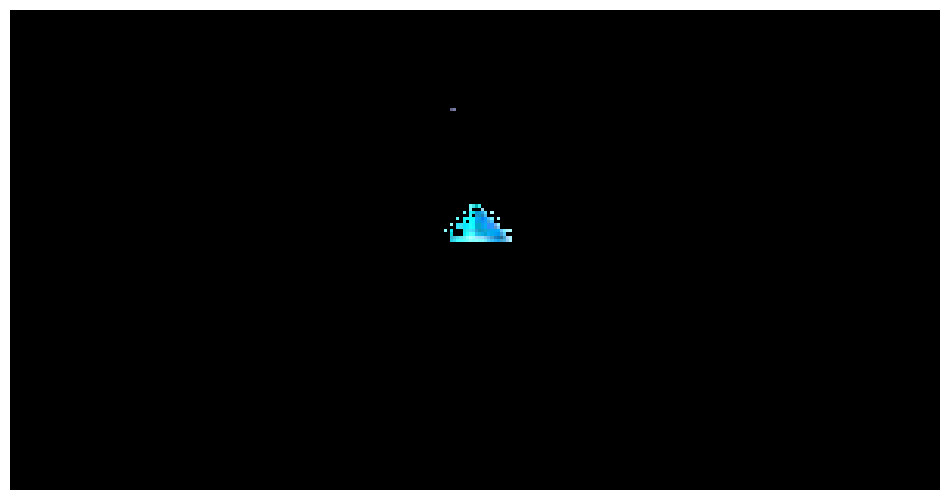

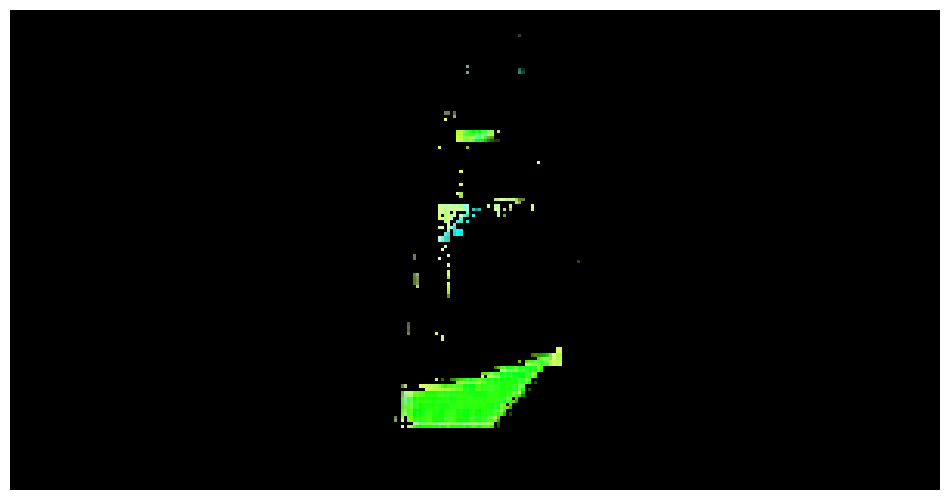

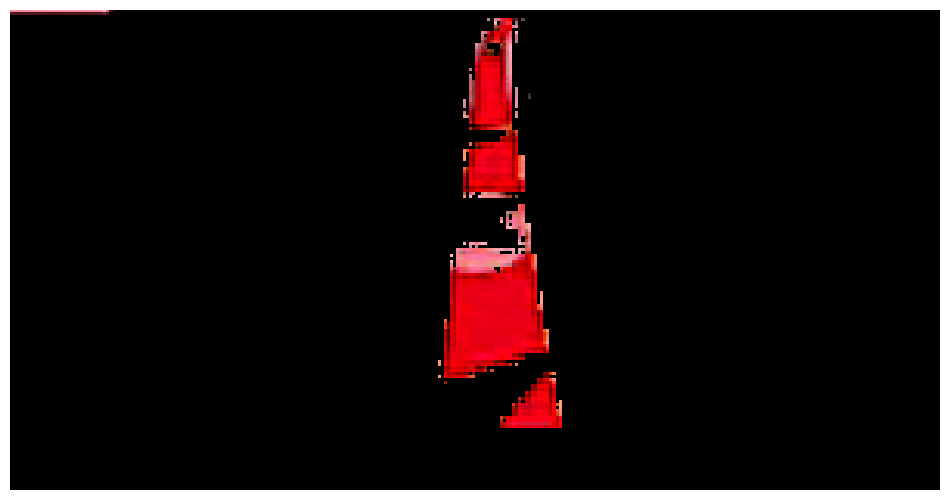

In [55]:
show(blue_nav_img)
show(green_nav_img)
show(red_nav_img)

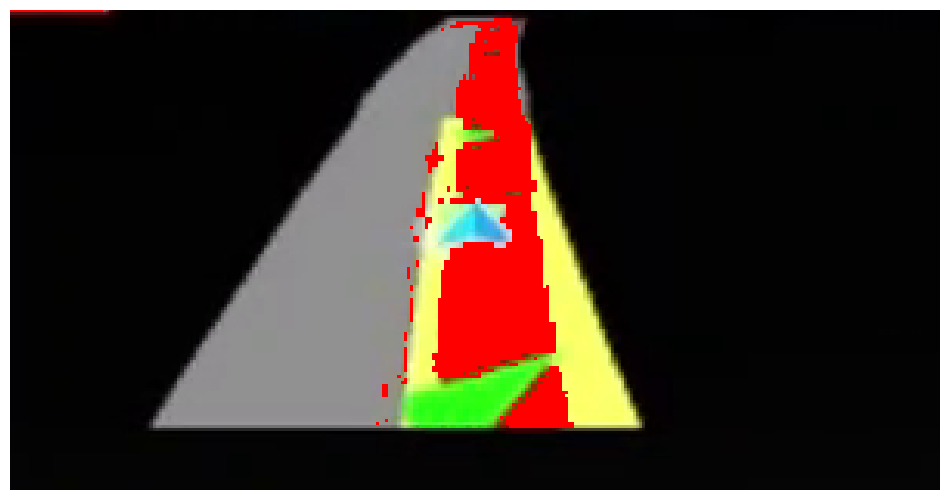

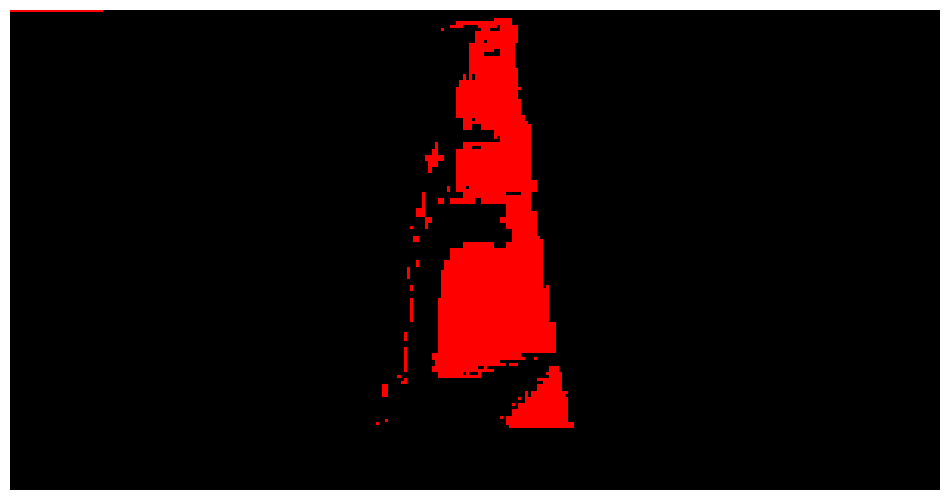

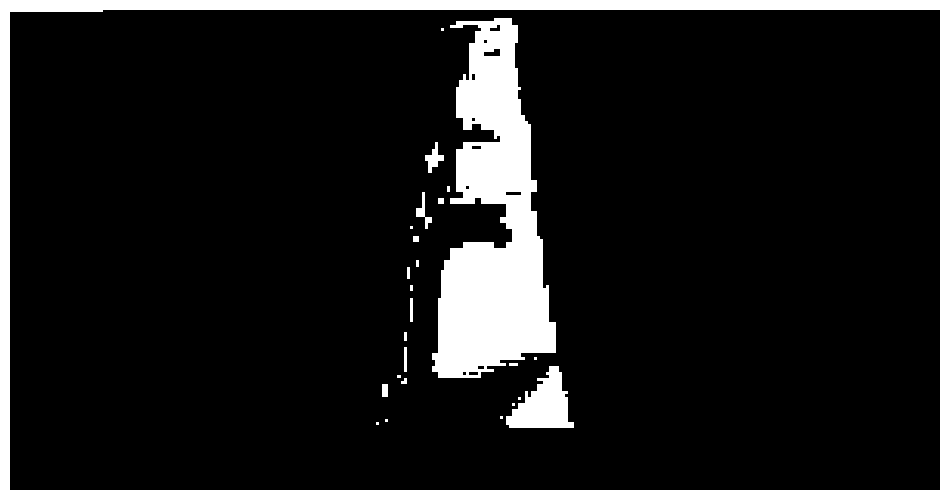

In [105]:
# Split channels
b, g, r = cv2.split(nav_img)

# greater than other channels by margin
threshold = 150
red_dominant = (r > threshold) & (r > g) & (r > b)

red_only_img = np.zeros_like(nav_img)
red_only_full = nav_img.copy()

red_only_full[red_dominant] = [0, 0, 255]
red_only_img[red_dominant] = [0, 0, 255]

# create a binary version
gray = cv2.cvtColor(red_only_img, cv2.COLOR_BGR2GRAY)
_, binary_red_only_img = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

show(red_only_full)
show(red_only_img)
show(binary_red_only_img)

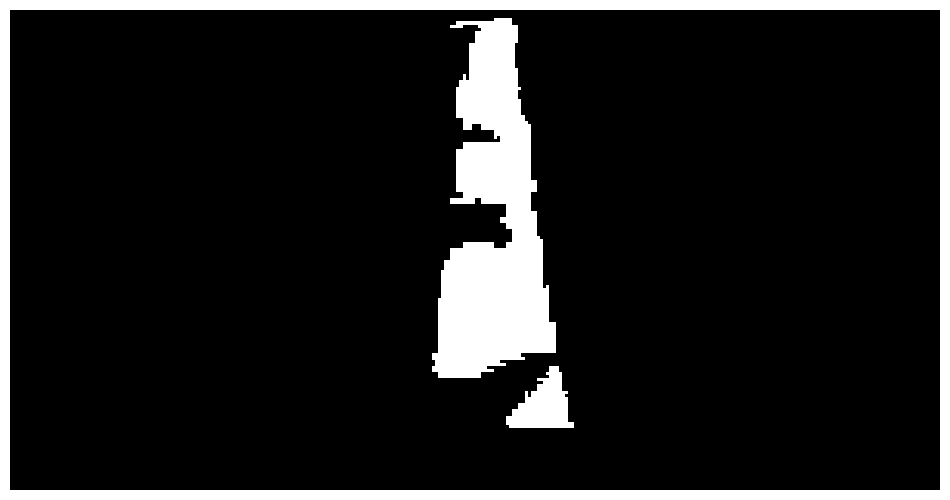

In [120]:
# find contours
contours, _ = cv2.findContours(binary_red_only_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

filtered = np.zeros_like(binary_red_only_img)

min_area = 50

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area >= min_area:
        cv2.drawContours(filtered, [cnt], -1, 255, thickness=cv2.FILLED)

show(filtered)

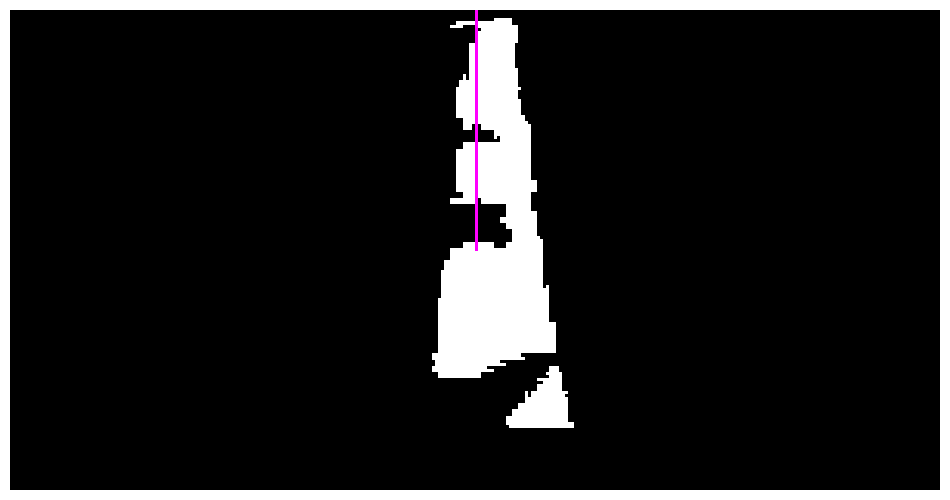

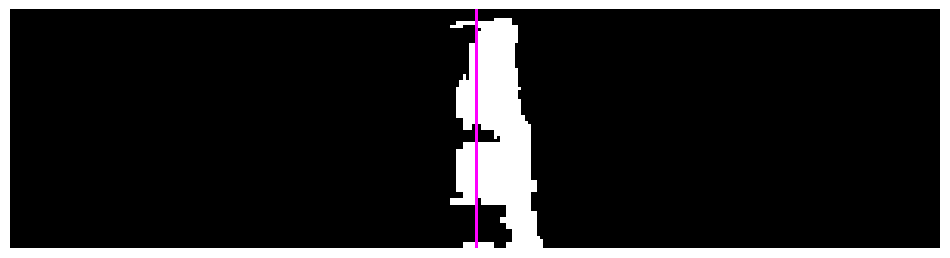

In [121]:
center = height + width // 2
guiedlines = filtered.copy()
guiedlines = cv2.cvtColor(guiedlines, cv2.COLOR_BGR2RGB)
height, width = guiedlines.shape[:2]
cv2.line(guiedlines, (width // 2, 0), (width // 2, height // 2), (255, 0, 255), 1)

show(guiedlines)
show(guiedlines[:height // 2, :])

Check of off the red (white) area is of the center and show the offset from -100 (left) to 100 (right)

In [124]:
center_x = width // 2
top_half = filtered[:height // 2, :]

# get coordinates of white pixels (non-zero)
ys, xs = np.where(top_half == 255)

# left of center = negative, right = positiv
offsets = xs - center_x

bias = np.sum(offsets)
# normalize: max possible bias is all pixels at far left or right
max_bias = len(xs) * center_x

# weight in range [-100, 100]
weight = int((bias / max_bias) * 100)

print(weight)

4


Check how much red (white) is in front and output a value between 0 (no red) and 1 (full red)

In [137]:
center_x = width // 2
channel = 140
top_half = filtered[:height // 2, channel:width - channel]

# get coordinates of white pixels (non-zero)
ys, xs = np.where(top_half == 255)

# catch a 0 if there a no white pixels (division by 0 error)
white_pxl = (len(xs) / top_half.size) if len(xs) > 0 else 0

print(white_pxl)

0.5298701298701298


## The final solution.

In [143]:
def get_roi():
    img = get_random_from_video()

    height, width = img.shape[:2]
    
    # --- navigation crop ---
    nav_top = 28
    nav_bottom = height - 900 
    nav_left = 810
    nav_right = width - 810 
    
    nav_img = img[nav_top:nav_bottom, nav_left:nav_right]
    
    # --- speed crop ---
    speed_top = 5 
    speed_bottom = height - 1057
    speed_left = 770
    speed_right = width - 1125

    speed_img = img[speed_top:speed_bottom, speed_left:speed_right]

    return img, nav_img, speed_img

In [237]:
def get_speed(speed_img):
    # convert to gray
    gray = cv2.cvtColor(speed_img, cv2.COLOR_BGR2GRAY)
    
    # sharpen
    blurred = cv2.GaussianBlur(gray, (0, 0), sigmaX=2)
    amount = 1.5
    sharpend = cv2.addWeighted(gray, 1 + amount, blurred, -amount, 0)
    
    # get binary representation
    _, binary_img = cv2.threshold(sharpend, 200, 255, cv2.THRESH_BINARY)

    # get speed
    binary_img_rgb = cv2.cvtColor(binary_img, cv2.COLOR_BGR2RGB)
    results = reader.readtext(binary_img_rgb, detail=0)

    show(binary_img)

    # check if we somehow have more than one result
    if len(results) != 1:
        return None
    else:
        # if the result is an integer, so numeric
        try:
            return int(results[0])
        except: 
            return None
    

In [235]:
def get_direction(nav_img):
    height, width, _ =  nav_img.shape
    
    # get the red values
    b, g, r = cv2.split(nav_img)
    threshold = 150
    red_dominant = (r > threshold) & (r > g) & (r > b)

    red_only_img = np.zeros_like(nav_img)
    red_only_img[red_dominant] = [0, 0, 255]

    # create a binary version
    gray = cv2.cvtColor(red_only_img, cv2.COLOR_BGR2GRAY)
    _, binary_red_only_img = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # find contours
    contours, _ = cv2.findContours(binary_red_only_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    countured = np.zeros_like(binary_red_only_img)
    min_area = 50
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area >= min_area:
            cv2.drawContours(countured, [cnt], -1, 255, thickness=cv2.FILLED)

    # get pixel bias
    center_x = width // 2
    top_half = countured[:height // 2, :]
    ys, xs = np.where(top_half == 255)
    offsets = xs - center_x
    bias = np.sum(offsets)
    max_bias = len(xs) * center_x
    weight = int((bias / max_bias) * 100)

    # get the amount of "front pixels"
    center_pillar_crop = 140
    pillar = countured[:height // 2, center_pillar_crop:width - center_pillar_crop]
    ys, xs = np.where(pillar == 255)
    centered_value = (len(xs) / pillar.size) if len(xs) > 0 else 0

    # give advice
    # if the road is left but we are in the center
    if weight <= -5 and centered_value >= 0.5:
        return f"Change Lane Left with weight: {weight} and centere value: {centered_value}"
    elif weight >= 5 and centered_value >= 0.5:
        return f"Change Lane Rigth with weight: {weight} and centere value: {centered_value}"
    elif weight <= -40 and centered_value < 0.5:
        return f"Turn Left with weight: {weight} and centere value: {centered_value}"
    elif weight >= 40 and centered_value < 0.5:
        return f"Turn Right with weight: {weight} and centere value: {centered_value}"
    elif -5 < weight < 5 and centered_value >= 0.5:
        return f"Stay on the track with weight: {weight} and centere value: {centered_value}"
    else:
        return None

In [222]:
def draw_guids(img):
    guiedlines = img.copy()
    height, width = guiedlines.shape[:2]
    cv2.line(guiedlines, (width // 2, 0), (width // 2, height // 2), (255, 0, 255), 1)

    show(guiedlines[:height // 2, :])

In [243]:
original_img, nav_img, speed_img = get_roi()

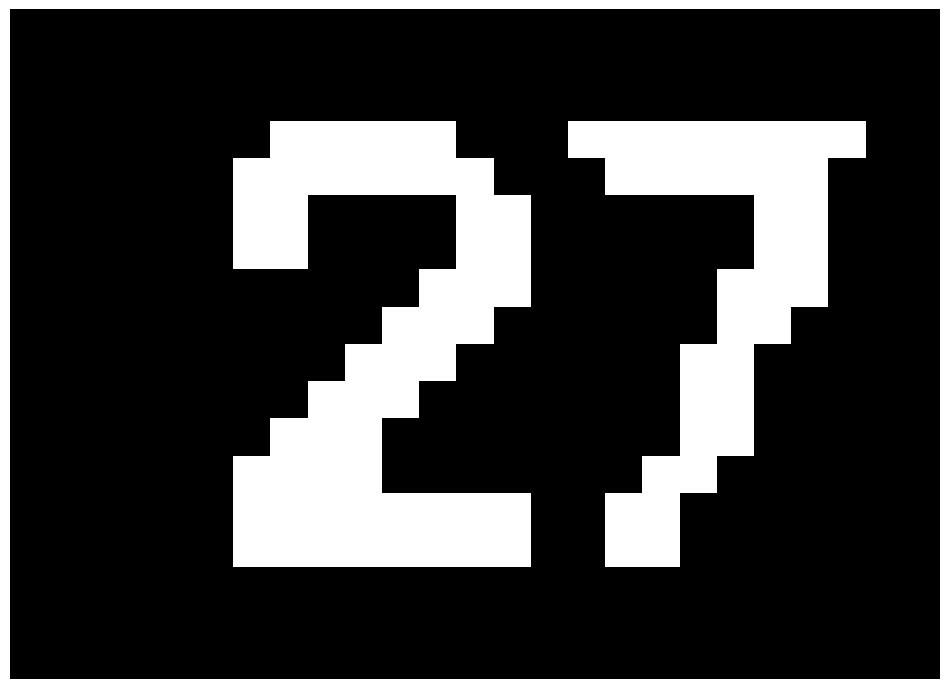

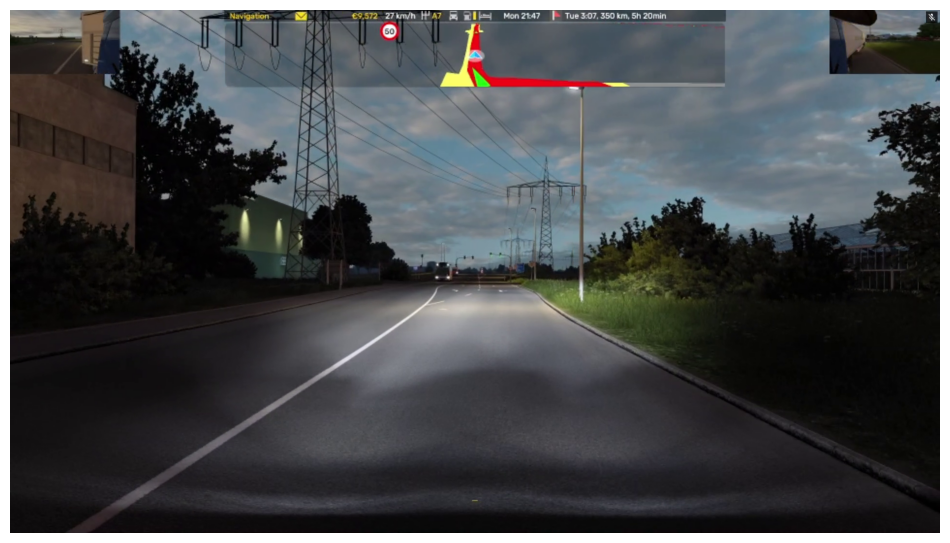

The speed is: 27
Stay on the track with weight: 0 and centere value: 0.7269736842105263


In [244]:
speed = get_speed(speed_img)
nav_advice = get_direction(nav_img)

show(original_img)

if speed:
    print(f"The speed is: {speed}")
else: 
    print("Could not detect speed.")
if nav_advice:
    print(nav_advice)
else:
    print("No route found.")


## Possible Problems
- Sometimes the speed is not detected correct, like digets are forgotten or digets are missclassified.
- When the red road guid is slighly curved left and the truck is on the left of the track,the overall weight is small.
- The binary variant should be inproved through speed detection.